In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.fft import fft
from skimage import feature
import scipy
from lightgbm import LGBMClassifier, LGBMRegressor
import shap
from sklearn.metrics import roc_auc_score, r2_score, mean_absolute_error

ModuleNotFoundError: No module named 'skimage'

In [ ]:
df = pd.read_csv('../data/train_logs.csv')
scores = pd.read_csv('../data/train_scores.csv')
df = df.merge(scores, on='id')
y_train = scores['score']

df['pos'] = df['cursor_position']% 10
df['line'] = (df['cursor_position']/10).astype(int)

In [ ]:
# Optimize the function to calculate top N frequencies and their magnitudes for each 'id' using groupby and apply
def calculate_fft_features(group):

    group['pos'] = group['cursor_position']%30
    group['line'] = (group['cursor_position']/30).astype(int)

    # Perform Fourier Transform on 'pos'
    fft_values = fft(group['pos'])[1:]
    
    # Generate frequencies corresponding to the Fourier Transform values
    frequencies = np.fft.fftfreq(len(fft_values), 1)[1:]
    
    # Take absolute value to get magnitude
    fft_magnitude = np.abs(fft_values)
    
    # Identify indices where the frequencies are positive
    positive_indices = np.where(frequencies > 0)[0]
    
    # Filter out only positive frequencies and skip the zero frequency
    frequencies = frequencies[positive_indices]
    magnitudes = fft_magnitude[positive_indices]
    
    # Frequency Domain Features
    peak_freq = frequencies[np.argmax(magnitudes)]
    mean_freq = np.average(frequencies, weights=magnitudes)
    median_freq = frequencies[len(magnitudes) // 2]
    bandwidth = np.ptp(frequencies)
    freq_skewness = scipy.stats.skew(magnitudes)
    freq_kurtosis = scipy.stats.kurtosis(magnitudes)

    # Other Features
    total_energy = np.sum(magnitudes ** 2)
    
    # Spectral Entropy
    psd_norm = np.abs(magnitudes) / np.sum(np.abs(magnitudes))
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + np.finfo(float).eps))
    
    # Spectral Flatness
    spectral_flatness = np.exp(np.mean(np.log(magnitudes + np.finfo(float).eps))) / np.mean(magnitudes)
    
    # Spectral Roll-off
    spectral_sum = np.cumsum(magnitudes)
    spectral_rolloff = frequencies[np.searchsorted(spectral_sum, 0.85 * spectral_sum[-1])]
    
    # Statistical Features
    mean_amplitude = np.mean(magnitudes)
    std_amplitude = np.std(magnitudes)
    skew_amplitude = scipy.stats.skew(magnitudes)
    kurtosis_amplitude = scipy.stats.kurtosis(magnitudes)

    features = {
        "Peak Frequency": peak_freq,
        "Mean Frequency": mean_freq,
        "Median Frequency": median_freq,
        "Bandwidth": bandwidth,
        "Frequency Skewness": freq_skewness,
        "Frequency Kurtosis": freq_kurtosis,
        "Total Energy": total_energy,
        "Spectral Entropy": spectral_entropy,
        "Spectral Flatness": spectral_flatness,
        "Spectral Roll-off": spectral_rolloff,
        "Mean Amplitude": mean_amplitude,
        "Std Amplitude": std_amplitude,
        "Skew Amplitude": skew_amplitude,
        "Kurtosis Amplitude": kurtosis_amplitude
    }
    
    return pd.Series(features)

# Use groupby and apply to optimize the calculation
x_train = df.groupby('id').apply(calculate_fft_features).reset_index(drop=True)

In [ ]:
def get_preds_shaps(x_train, target, ix_trn):
  model = LGBMRegressor().fit(x_train.loc[ix_trn], target[ix_trn])
  preds = pd.Series(model.predict(x_train), index=x_train.index)
  shap_explainer = shap.TreeExplainer(model)
  shaps = pd.DataFrame(
    data=shap_explainer.shap_values(x_train),
    index=x_train.index,
    columns=x_train.columns)
  return preds, shaps

In [ ]:
def get_feature_contributions(y_true, y_pred, shap_values):
  """Compute prediction contribution and error contribution for each feature."""

  prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")

  abs_error = (y_true - y_pred).abs()
  y_pred_wo_feature = shap_values.apply(lambda feature: y_pred - feature)
  abs_error_wo_feature = y_pred_wo_feature.apply(lambda feature: (y_true - feature).abs())
  error_contribution = abs_error_wo_feature.apply(lambda feature: abs_error - feature).mean().rename("error_contribution")
      
  return prediction_contribution, error_contribution

In [ ]:
fold = np.random.choice(["trn", "val", "tst"], p=[2/3, 1/6, 1/6], size=len(x_train))

ix_trn = fold == "trn"
ix_val = fold == "val"
ix_tst = fold == "tst"

In [ ]:
assert (ix_trn.astype(int) + ix_val.astype(int) + ix_tst.astype(int) == 1).all()

In [ ]:
preds, shaps = get_preds_shaps(x_train, target=y_train, ix_trn=ix_trn)

prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
  y_true=y_train.loc[ix_trn], 
  y_pred=preds.loc[ix_trn], 
  shap_values=shaps.loc[ix_trn, :]
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
  y_true=y_train.loc[ix_val], 
  y_pred=preds.loc[ix_val], 
  shap_values=shaps.loc[ix_val, :]
)

contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1625, number of used features: 14
[LightGBM] [Info] Start training from score 3.737846


Text(0, 0.5, 'Error Contribution')

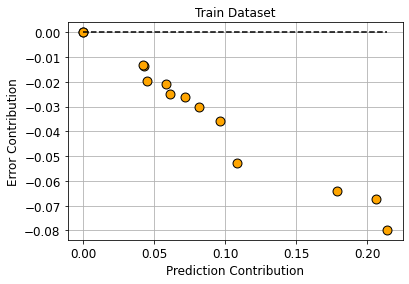

In [ ]:
fig, ax = plt.subplots()

ax.scatter(contributions_trn["prediction_contribution"], contributions_trn["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_trn["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid(); ax.set_axisbelow(True)
ax.set_title("Train Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

Text(0, 0.5, 'Error Contribution')

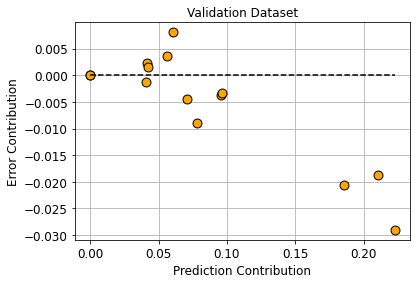

In [ ]:
fig, ax = plt.subplots()

ax.scatter(contributions_val["prediction_contribution"], contributions_val["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_val["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)

ax.grid()
ax.set_axisbelow(True)
ax.set_title("Validation Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

In [ ]:
rfe_error = pd.DataFrame(dtype=float)
features_curr = list(x_train.columns.copy())
feature_drop = None

for iteration in range(len(x_train.columns)):
  
  preds, shaps = get_preds_shaps(x_train[features_curr], target=y_train, ix_trn=ix_trn)
  prediction_contribution_val, error_contribution = get_feature_contributions(
    y_true=y_train.loc[ix_val], 
    y_pred=preds.loc[ix_val], 
    shap_values=shaps.loc[ix_val, :]
  )

  rfe_error.loc[iteration, "feature_drop"] = feature_drop
  rfe_error.loc[iteration, "n_features"] = len(features_curr)
  rfe_error.loc[iteration, "contrib"] = error_contribution.max()
  rfe_error.loc[iteration, "mae_trn"] = mean_absolute_error(y_train.loc[ix_trn], preds.loc[ix_trn])
  rfe_error.loc[iteration, "mae_val"] = mean_absolute_error(y_train.loc[ix_val], preds.loc[ix_val])
  rfe_error.loc[iteration, "mae_tst"] = mean_absolute_error(y_train.loc[ix_tst], preds.loc[ix_tst])
  rfe_error.loc[iteration, "r2_trn"] = r2_score(y_train.loc[ix_trn], preds.loc[ix_trn])
  rfe_error.loc[iteration, "r2_val"] = r2_score(y_train.loc[ix_val], preds.loc[ix_val])
  rfe_error.loc[iteration, "r2_tst"] = r2_score(y_train.loc[ix_tst], preds.loc[ix_tst])
  
  feature_drop = error_contribution.idxmax()
  features_curr.remove(feature_drop)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1625, number of used features: 14
[LightGBM] [Info] Start training from score 3.737846
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1625, number of used features: 13
[LightGBM] [Info] Start training from score 3.737846
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

In [ ]:
rfe_prediction = pd.DataFrame(dtype=float)
features_curr = list(x_train.columns.copy())
feature_drop = None

for iteration in range(len(x_train.columns)):
  
  preds, shaps = get_preds_shaps(x_train[features_curr], target=y_train, ix_trn=ix_trn)
  prediction_contribution, error_contribution = get_feature_contributions(
    y_true=y_train.loc[ix_val], 
    y_pred=preds.loc[ix_val], 
    shap_values=shaps.loc[ix_val, :]
  )

  rfe_prediction.loc[iteration, "feature_drop"] = feature_drop
  rfe_prediction.loc[iteration, "n_features"] = len(features_curr)
  rfe_prediction.loc[iteration, "contrib"] = prediction_contribution.min()
  rfe_prediction.loc[iteration, "mae_trn"] = mean_absolute_error(y_train.loc[ix_trn], preds.loc[ix_trn])
  rfe_prediction.loc[iteration, "mae_val"] = mean_absolute_error(y_train.loc[ix_val], preds.loc[ix_val])
  rfe_prediction.loc[iteration, "mae_tst"] = mean_absolute_error(y_train.loc[ix_tst], preds.loc[ix_tst])
  rfe_prediction.loc[iteration, "r2_trn"] = r2_score(y_train.loc[ix_trn], preds.loc[ix_trn])
  rfe_prediction.loc[iteration, "r2_val"] = r2_score(y_train.loc[ix_val], preds.loc[ix_val])
  rfe_prediction.loc[iteration, "r2_tst"] = r2_score(y_train.loc[ix_tst], preds.loc[ix_tst])
  
  feature_drop = prediction_contribution.idxmax()
  features_curr.remove(feature_drop)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1625, number of used features: 14
[LightGBM] [Info] Start training from score 3.737846
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1625, number of used features: 13
[LightGBM] [Info] Start training from score 3.737846
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('./output/rfe_error_0_fold.csv')

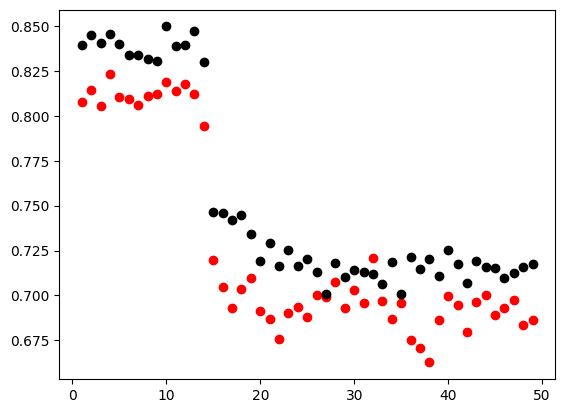

In [10]:
plt.plot(df['n_features'], df['rmse_tst'], 'ro')
plt.plot(df['n_features'], df['rmse_val'], 'ko')

FixedFormatter should only be used together with FixedLocator


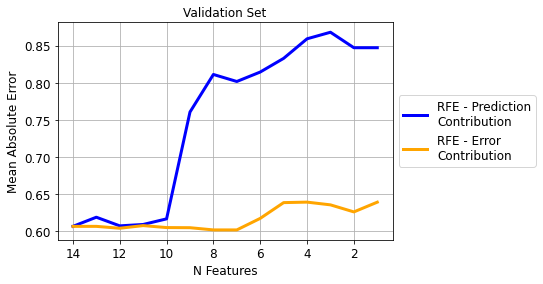

In [ ]:
fig, ax = plt.subplots()

ax.plot(-rfe_prediction["n_features"], rfe_prediction["mae_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error["n_features"], rfe_error["mae_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

In [ ]:
max_iter_show = len(rfe_error)

FixedFormatter should only be used together with FixedLocator


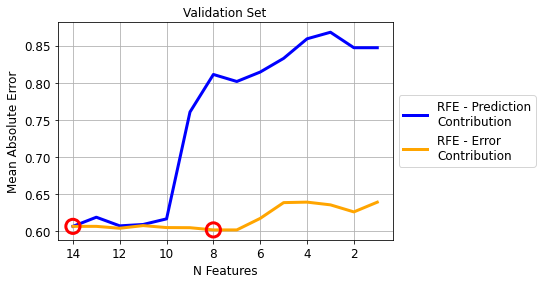

In [ ]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["mae_val"].idxmin()
idxmin_error = rfe_error["mae_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["mae_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["mae_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction,"n_features"], rfe_prediction.loc[idxmin_prediction,"mae_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error,"n_features"], rfe_error.loc[idxmin_error,"mae_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

FixedFormatter should only be used together with FixedLocator


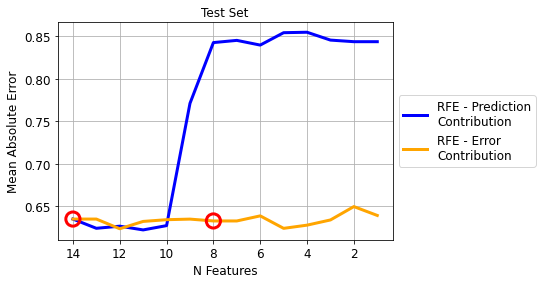

In [ ]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["mae_val"].idxmin()
idxmin_error = rfe_error["mae_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["mae_tst"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["mae_tst"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction,"n_features"], rfe_prediction.loc[idxmin_prediction,"mae_tst"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error,"n_features"], rfe_error.loc[idxmin_error,"mae_tst"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Test Set", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)